In [1]:
import time
start_time = time.time() # Allows the program's runtime to be measured
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [2]:
# pd.set_option('display.max_rows', 1000) # Useful for debugging

In [3]:
current_computer_nickname = 'ga15pyd' # Used for naming .csv files

database_paths_list = ['C:\\Users\\kburc\\AppData\\Local\\whatpulse\\whatpulse.db', 'C:\\Users\\kburc\\D1V1\\Documents\\whatpulse_database_backups\\a13r2_whatpulse.db'] # Necessary to escape the backslashes

In [4]:
def analyze_keypresses(database_path):
    file_name = database_path.split('\\')[-1]
    sqlalchemy_sqlite_engine = sqlalchemy.create_engine('sqlite:///'+database_path) # Based on https://docs.sqlalchemy.org/en/13/dialects/sqlite.html#connect-strings
    sqlalchemy_connection = sqlalchemy_sqlite_engine.connect()
    df_keypresses = pd.read_sql("select * from keypresses", con = sqlalchemy_sqlite_engine)
    df_keypresses.drop('hour',axis=1,inplace=True)    
    df_daily_keypresses = df_keypresses.groupby('day').sum()
    if '0000-00-00' in df_daily_keypresses.index:
        df_daily_keypresses.drop('0000-00-00',inplace=True)
    df_daily_keypresses.rename(columns={'count':'keypresses'},inplace=True)    
    df_daily_keypresses.sort_values('day',inplace=True)
    df_daily_keypresses['source'] = database_path.split('\\')[-1]
    print("\nNow analyzing", database_path.split('\\')[-1]+":")
    print("Total keypresses so far with this computer:",sum(df_daily_keypresses['keypresses']))
    print("Maximum keypresses in one day with this computer:",max(df_daily_keypresses['keypresses']))
    print("Average daily keypresses (at least for days with 1 or more keypresses):",np.mean(df_daily_keypresses['keypresses']))
    # plt.plot(df_daily_keypresses['keypresses'])
    return df_daily_keypresses

In [5]:
keypress_databases_list = []

for path in database_paths_list:
    keypress_databases_list.append(analyze_keypresses(path))

df_combined_daily_keypresses = pd.concat([keypress_databases_list[i] for i in range(len(keypress_databases_list))])
df_combined_daily_keypresses.sort_index(inplace=True)
df_combined_daily_keypresses = df_combined_daily_keypresses.groupby('day').sum() # This gets rid of the 'source' column, but that's OK, since this line is necessary to adjust for days where multiple computers were used.
df_combined_daily_keypresses.index = pd.to_datetime(df_combined_daily_keypresses.index)
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses



Now analyzing whatpulse.db:
Total keypresses so far with this computer: 4092799
Maximum keypresses in one day with this computer: 73788
Average daily keypresses (at least for days with 1 or more keypresses): 29234.27857142857

Now analyzing a13r2_whatpulse.db:
Total keypresses so far with this computer: 8493955
Maximum keypresses in one day with this computer: 77753
Average daily keypresses (at least for days with 1 or more keypresses): 30775.19927536232
410


,keypresses
day,
2020-09-21,19081
2020-09-22,32771
2020-09-23,32065
2020-09-24,34698
2020-09-25,47038
...,...
2021-11-06,29173
2021-11-07,2216
2021-11-08,54575


In [6]:
first_date = df_combined_daily_keypresses.index[0]
last_date = df_combined_daily_keypresses.index[-1]
full_date_range = pd.date_range(start=first_date, end = last_date) # https://pandas.pydata.org/docs/reference/api/pandas.date_range.html
df_combined_daily_keypresses = df_combined_daily_keypresses.reindex(full_date_range, fill_value=0)
df_combined_daily_keypresses.index.name = 'Date'
df_combined_daily_keypresses['7_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(7).mean()
df_combined_daily_keypresses['30_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(30).mean()
df_combined_daily_keypresses['365_day_ma'] = df_combined_daily_keypresses['keypresses'].rolling(365).mean()
print(len(df_combined_daily_keypresses))
df_combined_daily_keypresses

416


,keypresses,7_day_ma,30_day_ma,365_day_ma
Date,,,,
2020-09-21,19081,NaN,NaN,NaN
2020-09-22,32771,NaN,NaN,NaN
2020-09-23,32065,NaN,NaN,NaN
2020-09-24,34698,NaN,NaN,NaN
2020-09-25,47038,NaN,NaN,NaN
...,...,...,...,...
2021-11-06,29173,20727.571429,30843.866667,29458.400000
2021-11-07,2216,20044.000000,30467.600000,29407.750685
2021-11-08,54575,27302.142857,31425.700000,29495.630137


In [7]:
df_combined_daily_keypresses.tail(10) # Last 10 days of data

,keypresses,7_day_ma,30_day_ma,365_day_ma
Date,,,,
2021-11-01,3768,26077.714286,33103.966667,29658.849315
2021-11-02,0,17088.857143,32560.166667,29592.819178
2021-11-03,39306,15961.142857,32221.700000,29646.882192
2021-11-04,39199,14438.142857,31544.633333,29597.043836
2021-11-05,26646,18022.714286,31233.633333,29515.731507
2021-11-06,29173,20727.571429,30843.866667,29458.400000
2021-11-07,2216,20044.000000,30467.600000,29407.750685
2021-11-08,54575,27302.142857,31425.700000,29495.630137
2021-11-09,73788,37843.285714,32561.166667,29584.802740


In [8]:
np.linspace(0,1,101)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [9]:
df_combined_daily_keypresses.describe()

,keypresses,7_day_ma,30_day_ma,365_day_ma
count,416.000000,410.000000,387.000000,52.000000
mean,30256.620192,30233.859582,30099.888372,29782.341043
std,18372.536805,9818.632636,6670.876111,152.749986
min,0.000000,4266.142857,18423.300000,29407.750685
25%,16288.000000,23788.964286,23405.183333,29663.207534
50%,29078.500000,31217.642857,30962.400000,29835.327397
75%,44221.000000,37520.571429,35993.266667,29888.463699
max,77753.000000,50377.571429,41971.566667,30033.476712


In [10]:
df_combined_daily_keypresses['keypresses'].describe(percentiles=np.linspace(0.9,1,11))

count      416.000000
mean     30256.620192
std      18372.536805
min          0.000000
50%      29078.500000
90%      54777.000000
91%      55459.750000
92%      56724.400000
93%      58031.250000
94%      59533.200000
95%      60837.500000
96%      62551.000000
97%      65211.550000
98%      67208.600000
99%      70249.300000
100%     77753.000000
max      77753.000000
Name: keypresses, dtype: float64

(array([39., 24., 16., 22., 22., 34., 35., 27., 26., 33., 26., 25., 26.,
        14., 18., 11.,  8.,  5.,  2.,  3.]),
 array([    0.  ,  3887.65,  7775.3 , 11662.95, 15550.6 , 19438.25,
        23325.9 , 27213.55, 31101.2 , 34988.85, 38876.5 , 42764.15,
        46651.8 , 50539.45, 54427.1 , 58314.75, 62202.4 , 66090.05,
        69977.7 , 73865.35, 77753.  ]),
 <BarContainer object of 20 artists>)

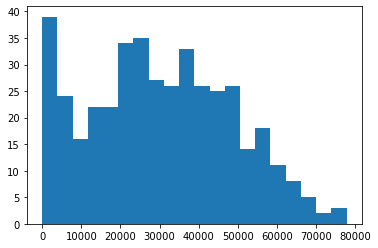

In [11]:
plt.hist(df_combined_daily_keypresses['keypresses'], bins = 20)

In [12]:
print("Total keypresess since", str(df_combined_daily_keypresses.index[0])+":",'{:,}'.format(sum(df_combined_daily_keypresses['keypresses'])))

Total keypresess since 2020-09-21 00:00:00: 12,586,754


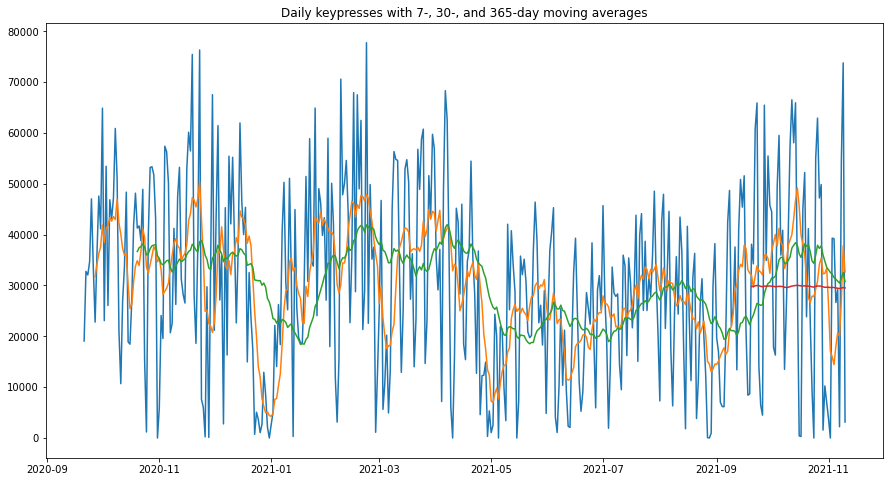

In [26]:
fig, axes = plt.subplots(figsize=[15,8])
fig.set_facecolor('white')
axes.plot(df_combined_daily_keypresses[['keypresses', '7_day_ma', '30_day_ma', '365_day_ma']])
plt.title('Daily keypresses with 7-, 30-, and 365-day moving averages')
plt.savefig('daily_keypresses_and_MAs.png', dpi=400)

List of tables in each WhatPulse database file:

In [14]:
# output = sqlalchemy_connection.execute("SELECT name FROM sqlite_schema WHERE type='table' ORDER BY name;") # From https://www.sqlite.org/faq.html#q7 
# print(output.all())
# Tables: [('application_active_hour',), ('application_bandwidth',), ('application_ignore',), ('application_uptime',), ('applications',), ('applications_upgrades',), ('computer_info',), ('country_bandwidth',), ('fact',), ('geekwindow_labels',), ('input_per_application',), ('keycombo_frequency',), ('keycombo_frequency_application',), ('keypress_frequency',), ('keypress_frequency_application',), ('keypresses',), ('last_update_time',), ('milestones',), ('milestones_log',), ('mouseclicks',), ('mouseclicks_frequency',), ('mouseclicks_frequency_application',), ('mousepoints',), ('network_interface_bandwidth',), ('network_interfaces',), ('network_interfaces_ignore',), ('network_protocol_bandwidth',), ('pending_applications_stats',), ('settings',), ('sqlite_sequence',), ('unpulsed_stats',), ('uptimes',)]

In [15]:
df_combined_daily_keypresses.to_csv('C:\\Users\\kburc\\D1V1\\Documents\\!Dell64docs\\!Organization\whatpulse_stats\\''whatpulse_daily_keypresses.csv')

In [16]:
df_daily_steps = pd.read_csv(r'C:\Users\kburc\D1V1\Documents\!Dell64docs\!Organization\fitbit_logs\MyFitbitData\KennethBurchfiel\Physical Activity\daily_steps.csv')
df_daily_steps['Date'] = pd.to_datetime(df_daily_steps['Date'])
df_daily_steps.set_index('Date',inplace=True)
df_daily_steps

,steps,7_day_avg
Date,,
2020-01-20,166,NaN
2020-01-21,4324,NaN
2020-01-22,7259,NaN
2020-01-23,8154,NaN
2020-01-24,15363,NaN
...,...,...
2021-09-12,12818,11290.857143
2021-09-13,14098,11986.714286
2021-09-14,15125,11664.428571


In [17]:
df_steps_keypresses = df_combined_daily_keypresses.merge(df_daily_steps,how='inner', on='Date')
df_steps_keypresses = df_steps_keypresses[['keypresses', 'steps']]
df_steps_keypresses

,keypresses,steps
Date,,
2020-09-21,19081,10074
2020-09-22,32771,2804
2020-09-23,32065,4896
2020-09-24,34698,6826
2020-09-25,47038,8294
...,...,...
2021-09-12,13412,12818
2021-09-13,40983,14098
2021-09-14,50865,15125


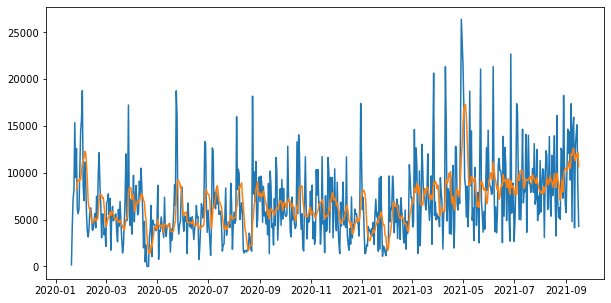

In [18]:
fig, axes = plt.subplots(figsize=[10, 5])
plt.plot(df_daily_steps)

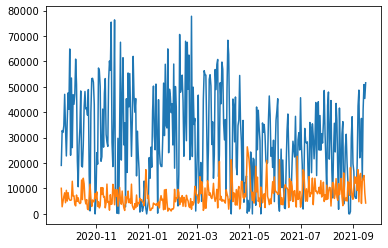

In [19]:
plt.plot(df_steps_keypresses)

In [20]:
# Based on https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
y = df_steps_keypresses['steps']
x = df_steps_keypresses['keypresses']
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  steps   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     104.8
Date:                Wed, 10 Nov 2021   Prob (F-statistic):           9.49e-22
Time:                        09:32:14   Log-Likelihood:                -3487.7
No. Observations:                 361   AIC:                             6979.
Df Residuals:                     359   BIC:                             6987.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.095e+04    394.106     27.774      0.000    1.02e+04    1.17e+04
keypresses    -0.1161      0.011    -10.237      0.000      -0.138      -0.094
==============================================================================
Omnibus:                       52.355   Durbin-Watson:                   1.487
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.887
Skew:                           0.914   Prob(JB):                     7.41e-18
Kurtosis:                       4.379   Cond. No.                     6.83e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
results.params

const         10945.953946
keypresses       -0.116115
dtype: float64

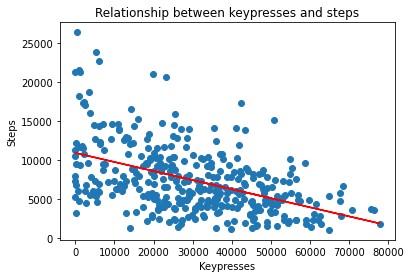

In [22]:
fig, axes = plt.subplots()
fig.set_facecolor('white')
plt.scatter(df_steps_keypresses['keypresses'], df_steps_keypresses['steps'])
plt.plot(df_steps_keypresses['keypresses'], results.params[0] + df_steps_keypresses['keypresses']*results.params[1], color='red')
plt.title("Relationship between keypresses and steps")
plt.xlabel('Keypresses')
plt.ylabel('Steps')
plt.savefig('keypresses_steps_scatter.png', dpi=400)

In [23]:
end_time = time.time()
run_time = end_time - start_time
run_minutes = run_time // 60
run_seconds = run_time % 60
print("Completed run at",time.ctime(end_time),"(local time)")
print("Total run time:",'{:.2f}'.format(run_time),"second(s) ("+str(run_minutes),"minute(s) and",'{:.2f}'.format(run_seconds),"second(s))") # Only meaningful when the program is run nonstop from start to finish


Completed run at Wed Nov 10 09:32:14 2021 (local time)
Total run time: 6.36 second(s) (0.0 minute(s) and 6.36 second(s))
